In [1]:
import h5py
import os

# Path to your PRISMA .he5 file
file = "/home/daljit/hyperspec_project/data/PRS_L1_STD_OFFL_20201229101250_20201229101254_0001.he5"

print("File exists:", os.path.exists(file))

with h5py.File(file, "r") as f:
    print("\nTop-level groups:")
    for key in f.keys():
        print(" -", key)

    print("\nAll datasets inside file:\n")

    def show(name, obj):
        if isinstance(obj, h5py.Dataset):
            print("Dataset:", name, "→ shape:", obj.shape)

    f.visititems(show)


File exists: True

Top-level groups:
 - HDFEOS
 - HDFEOS INFORMATION
 - Info
 - KDP_AUX

All datasets inside file:

Dataset: HDFEOS/SWATHS/PRS_L1_HCO/Data Fields/Cloud_Mask → shape: (1000, 1000)
Dataset: HDFEOS/SWATHS/PRS_L1_HCO/Data Fields/FrameNumber → shape: (1000,)
Dataset: HDFEOS/SWATHS/PRS_L1_HCO/Data Fields/LandCover_Mask → shape: (1000, 1000)
Dataset: HDFEOS/SWATHS/PRS_L1_HCO/Data Fields/SWIR_Cube → shape: (1000, 173, 1000)
Dataset: HDFEOS/SWATHS/PRS_L1_HCO/Data Fields/SWIR_PIXEL_SAT_ERR_MATRIX → shape: (1000, 173, 1000)
Dataset: HDFEOS/SWATHS/PRS_L1_HCO/Data Fields/SunGlint_Mask → shape: (1000, 1000)
Dataset: HDFEOS/SWATHS/PRS_L1_HCO/Data Fields/VNIR_Cube → shape: (1000, 66, 1000)
Dataset: HDFEOS/SWATHS/PRS_L1_HCO/Data Fields/VNIR_PIXEL_SAT_ERR_MATRIX → shape: (1000, 66, 1000)
Dataset: HDFEOS/SWATHS/PRS_L1_HCO/Geolocation Fields/Latitude_SWIR → shape: (1000, 1000)
Dataset: HDFEOS/SWATHS/PRS_L1_HCO/Geolocation Fields/Latitude_VNIR → shape: (1000, 1000)
Dataset: HDFEOS/SWATHS/PR

VNIR shape: (1000, 66, 1000)
SWIR shape: (1000, 173, 1000)
Latitude shape: (1000, 1000)
Longitude shape: (1000, 1000)


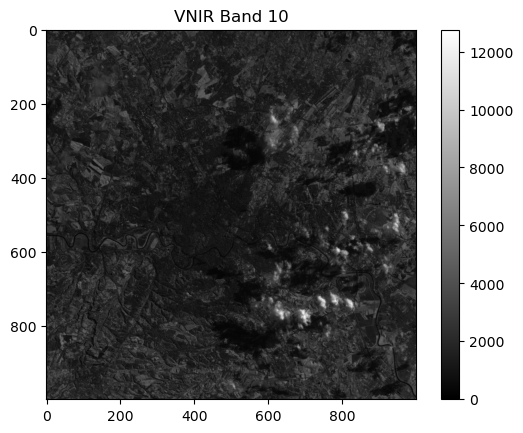

In [2]:
# extract_prisma
import h5py
import numpy as np
import matplotlib.pyplot as plt

file = "/home/daljit/hyperspec_project/data/PRS_L1_STD_OFFL_20201229101250_20201229101254_0001.he5"

with h5py.File(file, "r") as f:

    # VNIR cube (1000, 66, 1000)
    vnir = f["HDFEOS/SWATHS/PRS_L1_HCO/Data Fields/VNIR_Cube"][:]
    print("VNIR shape:", vnir.shape)

    # SWIR cube (1000, 173, 1000)
    swir = f["HDFEOS/SWATHS/PRS_L1_HCO/Data Fields/SWIR_Cube"][:]
    print("SWIR shape:", swir.shape)

    # Geolocation
    lat = f["HDFEOS/SWATHS/PRS_L1_HCO/Geolocation Fields/Latitude_VNIR"][:]
    lon = f["HDFEOS/SWATHS/PRS_L1_HCO/Geolocation Fields/Longitude_VNIR"][:]

    print("Latitude shape:", lat.shape)
    print("Longitude shape:", lon.shape)

# Show VNIR band 10
plt.imshow(vnir[:, 10, :], cmap="gray")
plt.title("VNIR Band 10")
plt.colorbar()
plt.show()



In [3]:
# combine_cube : Rearrange the axes, merges them into one big cube
import h5py
import numpy as np

# Path to your file
file = "/home/daljit/hyperspec_project/data/PRS_L1_STD_OFFL_20201229101250_20201229101254_0001.he5"

print("Loading data...")

with h5py.File(file, "r") as f:

    # Load VNIR (1000 x 66 x 1000)
    vnir = f["HDFEOS/SWATHS/PRS_L1_HCO/Data Fields/VNIR_Cube"][:]
    print("VNIR:", vnir.shape)

    # Load SWIR (1000 x 173 x 1000)
    swir = f["HDFEOS/SWATHS/PRS_L1_HCO/Data Fields/SWIR_Cube"][:]
    print("SWIR:", swir.shape)

# IMPORTANT: Move the band axis to the END
# Current:   rows, bands, cols
# Required:  rows, cols, bands

vnir = np.transpose(vnir, (0, 2, 1))
swir = np.transpose(swir, (0, 2, 1))

print("VNIR reordered:", vnir.shape)
print("SWIR reordered:", swir.shape)

# Now stack them along the last axis (bands)
full_cube = np.concatenate((vnir, swir), axis=2)

print("Full cube shape:", full_cube.shape)

# Save combined cube as .npy (fast and safe)
np.save("/home/daljit/hyperspec_project/full_cube.npy", full_cube)

print("Saved full hyperspectral cube as full_cube.npy")


Loading data...
VNIR: (1000, 66, 1000)
SWIR: (1000, 173, 1000)
VNIR reordered: (1000, 1000, 66)
SWIR reordered: (1000, 1000, 173)
Full cube shape: (1000, 1000, 239)
Saved full hyperspectral cube as full_cube.npy


In [ ]:
# add noise for testing
import numpy as np
import matplotlib.pyplot as plt

# 1. Load your corrected cube (or full_cube)
cube = np.load("/home/daljit/hyperspec_project/full_cube.npy")
print("Original cube shape:", cube.shape)

# 2. Convert to float (important for noise math)
cube = cube.astype(np.float32)

# 3. Define noise level
noise_std = 0.05 * np.mean(cube)  
# 5% of mean signal → realistic noise

# 4. Generate Gaussian noise
noise = np.random.normal(
    loc=0.0,
    scale=noise_std,
    size=cube.shape
)

# 5. Add noise
noisy_cube = cube + noise

# 6. Avoid negative values
noisy_cube[noisy_cube < 0] = 0

# 7. Save noisy cube
np.save("/home/daljit/hyperspec_project/noisy_cube.npy", noisy_cube)

print("Noise added and saved as noisy_cube.npy")
print("Original mean:", cube.mean())
print("Noisy mean:", noisy_cube.mean())


band = 30  # any band

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.title("Original")
plt.imshow(cube[:,:,band], cmap="gray")
plt.colorbar()

plt.subplot(1,2,2)
plt.title("With Noise")
plt.imshow(noisy_cube[:,:,band], cmap="gray")
plt.colorbar()

plt.show()